# Assignment 2: N-grams and Language Identification
## CNG463 - Introduction to Natural Language Processing
### METU NCC Computer Engineering | Fall 2025-26

**Student Name:**Berkay Yeriçer
**Student ID:**238572
**Due Date:** 16 November 2025 (Sunday) before midnight

---

## Overview

This assignment focuses on:
1. Building **character-based** 2-gram and 3-gram language models with Laplace smoothing
2. Sentence-based language identification using 10-fold cross-validation
3. Evaluation using accuracy, precision, recall, and F1-score
4. Comparison and analysis

**Note:** For language identification, we use **character n-grams** rather than word n-grams because they better capture language-specific patterns like letter combinations, diacritics, and writing systems.

**Grading:**
- Written Questions (7 × 4 pts): **28 pts**
- Code Tasks with TODO (11 total): **72 pts** distributed by effort level:
  - Simple tasks: 4 pts each (2 cells)
  - Moderate tasks: 6 pts each (4 cells)
  - Complex tasks: 8 pts each (5 cells)
- **Total: 100 pts**

---

## Pre-Submission Checklist

- [ ] Name and student ID at top
- [ ] No cells are added or removed
- [ ] All TODO sections completed
- [ ] All questions answered
- [ ] Code runs without errors
- [ ] Results tables included
- [ ] Run All before saving

## Setup and Imports

In [ ]:
# Standard libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict, Counter
from typing import List, Tuple, Dict
import re


# Scikit-learn for cross-validation and metrics
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
from scipy.stats import ttest_rel


# Set random seed for reproducibility
np.random.seed(42)

---

# Task 1: Corpus Preparation and Statistics (22 points)

## 1.1: Upload Corpus Files

Prepare your text files in **two different languages** (accepted formats: `.txt`, `.pdf`, or `.docx`). When you run the cell below, you'll be prompted to upload files for each language separately. Make sure your files contain substantial text (reports, essays, or similar content from other courses). Each language requires at least **5000** words in its corpus.

In [ ]:
from google.colab import files

print("Upload your ENGLISH corpus file(s):")
english_files = files.upload()

print("\nUpload your SECOND LANGUAGE corpus file(s):")
second_lang_files = files.upload()


Upload your ENGLISH corpus file(s):


Saving Alice’s Adventures in Wonderland – Lewis Carroll.txt to Alice’s Adventures in Wonderland – Lewis Carroll (2).txt

Upload your SECOND LANGUAGE corpus file(s):


Saving Arif Kaptan - Giyotinli Labirent_djvu.txt to Arif Kaptan - Giyotinli Labirent_djvu (2).txt


## 1.2: Load and Preprocess Data (12 points)

Load your uploaded files, extract text, preprocess, split into sentences, and tokenize. You'll need helper functions to handle different file formats.

**Steps:**
1. Read files based on format (`.txt`, `.pdf`, `.docx`) and combine them into single text for each language
2. Apply preprocessing (e.g., lowercasing, handling punctuation)
3. Split each corpus into individual sentences
4. Tokenize each sentence into words (for statistics)
5. Store the results as two lists of tokenized sentences

**Important:** You'll use word tokenization for calculating statistics, but for the n-gram models in Task 2, you'll work with character n-grams directly on the sentence strings.

In [ ]:
!pip install PyPDF2
!pip install python-docx

import os
import io
import re
from typing import List, Iterable
import PyPDF2
import docx


def read_txt_file(filename: str) -> str:
    """Read a .txt file and return its content."""
    with open(filename, 'r', encoding='utf-8') as f:
        return f.read()

def read_pdf_file(filename: str) -> str:
    """Read a .pdf file and return its text content."""
    text = ""
    with open(filename, "rb") as f:
        pdf_reader = PyPDF2.PdfReader(f)
        for page in pdf_reader.pages:
            page_text = page.extract_text()
            if page_text is not None:
                text += page_text + "\n"
    return text

def read_any_file(filename: str) -> str:
    """Read .txt, .pdf or .docx file depending on extension."""
    _, ext = os.path.splitext(filename)
    ext = ext.lower()

    if ext == ".txt":
        return read_txt_file(filename)
    elif ext == ".pdf":
        return read_pdf_file(filename)
    elif ext == ".docx":
        return read_docx_file(filename)
    else:
        raise ValueError("Unsupported file type: " + ext)


def read_docx_file(filename: str) -> str:
    """Read a .docx file and return its text content."""
    text = ""
    doc = docx.Document(filename)
    for paragraph in doc.paragraphs:
        text += paragraph.text + "\n"
    return text

def text_normalizer(text:str, lower:bool=False)->str:
    text = re.sub(r"\s+", " ", text)
    text = text.strip()
    if lower:
        text = text.lower()
    return text

def split_into_sentences(text: str) -> List[str]:
    """Split text into sentences."""
    pattern = r'(?<=[.!?])\s+'
    pieces = re.split(pattern, text)
    sentences: List[str] = []
    for s in pieces:
        if s is not None:
            s = s.strip()
            if s != "":
                sentences.append(s)
    return sentences

TOKEN_RE = re.compile(
    r"[A-Za-zÇĞİÖŞÜçğıöşü0-9']+|[^\w\s]",
    flags=re.UNICODE
)

def tokenize_sentence(sentence: str) -> List[str]:
    """Tokenize a sentence into words."""
    sentence = sentence.lower()
    tokens = TOKEN_RE.findall(sentence)
    clean_tokens: List[str] = []
    for t in tokens:
        if t is not None and t.strip() != "":
            clean_tokens.append(t)

    return clean_tokens

def combine_files(files: Iterable[str])->str:
    all_text = ""
    for fp in files:
        file_text = read_any_file(fp)
        all_text += file_text + "\n"
    return all_text

def corpus_to_sentences_and_tokens(files:Iterable[str]):
    if not files:
          return [], []

    raw_text = combine_files(files)
    raw_text = text_normalizer(raw_text, lower=False)
    sentences_raw = split_into_sentences(raw_text)
    sentences_tok: List[List[str]] = []
    for s in sentences_raw:
        tokens = tokenize_sentence(s)
        sentences_tok.append(tokens)
    return sentences_raw, sentences_tok

lang1_files = [
    "/content/Alice’s Adventures in Wonderland – Lewis Carroll.txt"
]

lang2_files = [
    "/content/Arif Kaptan - Giyotinli Labirent_djvu.txt"
]

if lang1_files:
    lang1_sentences, lang1_sentences_tokenized = corpus_to_sentences_and_tokens(lang1_files)
else:
    lang1_sentences, lang1_sentences_tokenized = [], []

if lang2_files:
    lang2_sentences, lang2_sentences_tokenized = corpus_to_sentences_and_tokens(lang2_files)
else:
    lang2_sentences, lang2_sentences_tokenized = [], []


print("[Lang1] #Sentences:", len(lang1_sentences),
      "| #tokenized sentences:", len(lang1_sentences_tokenized))

if lang1_sentences_tokenized:
    total_tokens_l1 = 0
    vocab_l1 = set()

    for sent in lang1_sentences_tokenized:
        total_tokens_l1 += len(sent)
        for tok in sent:
            vocab_l1.add(tok)

    print("[Lang1] #tokens:", total_tokens_l1,
          "| #types:", len(vocab_l1))


print("[Lang2] #Sentences:", len(lang2_sentences),
      "| #tokenized sentences:", len(lang2_sentences_tokenized))

if lang2_sentences_tokenized:
    total_tokens_l2 = 0
    vocab_l2 = set()

    for sent in lang2_sentences_tokenized:
        total_tokens_l2 += len(sent)
        for tok in sent:
            vocab_l2.add(tok)

    print("[Lang2] #tokens:", total_tokens_l2,
          "| #types:", len(vocab_l2))

[Lang1] #Sentences: 916 | #tokenized sentences: 916
[Lang1] #tokens: 33304 | #types: 2509
[Lang2] #Sentences: 2434 | #tokenized sentences: 2434
[Lang2] #tokens: 29548 | #types: 9751


**Question 1.1:** What preprocessing choices did you make and why? (3-5 sentences)

**Hocam first of all I implemented basic file readers.After that the most important thing is normalizing the text. So i normalized by collapsing multiple spaces into one space and trimming extra whitespace, i did this steps because it is important for sentence splitting and tokenization. After that for segmentation i used basic regular expression(actually i tried to use more complex versions but it didnt work ,I dont know why, so i keep them as a basic expressions.)For tokenization i dont want to use the library tokenization, i just want to try in a different way, so i used lightweight regex  tokenizer for kepps words, numbers and punctutions as seperate tokens, because it is important for keeping statistics.**

## 1.3: Basic Statistics (10 points)

Calculate and display key statistics for both language corpora to understand their characteristics.

In [ ]:
import numpy as np
import collections

def simple_corpus_stats(sentences, tokenized_sentences, lang_name=""):
    """Compute basic corpus statistics in a simple and readable way."""

    # These for total character count
    total_chars = 0
    for sent in sentences:
        total_chars += len(sent)

    # These for special character count
    special_chars = 0
    for sent in sentences:
        for ch in sent:
            if not ch.isalnum() and not ch.isspace():
                special_chars += 1

    # These for Character vocabulary size
    char_vocab = set()
    for sent in sentences:
        for ch in sent:
            char_vocab.add(ch)
    char_vocab_size = len(char_vocab)

    # These for total word count
    total_words = 0
    for sent in tokenized_sentences:
        total_words += len(sent)

    # These for word vocabulary size
    word_vocab = set()
    for sent in tokenized_sentences:
        for tok in sent:
            word_vocab.add(tok)
    word_vocab_size = len(word_vocab)

    # These for sentence count
    num_sentences = len(sentences)

    # These for average sentence length
    if num_sentences > 0:
        avg_sentence_len = total_words / num_sentences
    else:
        avg_sentence_len = 0

    print("\n****** {} Corpus Statistics *****".format(lang_name))
    print("Total characters:", total_chars)
    print("Special characters:", special_chars)
    print("Character vocabulary size:", char_vocab_size)
    print("Total words:", total_words)
    print("Word vocabulary size:", word_vocab_size)
    print("Sentence count:", num_sentences)
    print("Average sentence length (words):", round(avg_sentence_len, 2))

    # return a dictionary if needed later
    return {
        "total_chars": total_chars,
        "special_chars": special_chars,
        "char_vocab_size": char_vocab_size,
        "total_words": total_words,
        "word_vocab_size": word_vocab_size,
        "num_sentences": num_sentences,
        "avg_sentence_len": avg_sentence_len
    }

stats_en = simple_corpus_stats(lang1_sentences, lang1_sentences_tokenized, "English")
stats_tr = simple_corpus_stats(lang2_sentences, lang2_sentences_tokenized, "Turkish")



****** English Corpus Statistics *****
Total characters: 133385
Special characters: 7969
Character vocabulary size: 75
Total words: 33304
Word vocabulary size: 2509
Sentence count: 916
Average sentence length (words): 36.36

****** Turkish Corpus Statistics *****
Total characters: 180266
Special characters: 5457
Character vocabulary size: 87
Total words: 29548
Word vocabulary size: 9751
Sentence count: 2434
Average sentence length (words): 12.14


**Question 1.2:** What are the key differences between your two corpora? (2-3 sentences)

**My opinion is there are two different key factors, the fırst one is book genre.Alice’s Adventures in Wonderland`s genre is childrens book so  we can say that the sentences are more fairytale-like and longer it is triple times longer than "Giyotinli labirent".According to this we can see the resultssome statistics. for example due to the long sentences,Alice's sentence count is triple times smaller than giyotili rehber. The second key factor is Languages are different. English texts contains more punctuation, reflecting different writing and stylistic conversation But turkish language has many unique word types due to morphology,like larger vocabulary even with fewer total tokens.In final we can say two different key factor we have, these are book genres and Language difference**

---

# Task 2: Character N-gram Language Identification (58 points)

**Baseline (46 pts):** Implement character-based 2-gram and 3-gram models, run 10-fold CV, report accuracy.  
**Creativity (12 pts):** Out-of-vocabulary analysis.

## 2.1: Implement Character N-gram Models (12 points)

Implement the `CharNgramLanguageModel` class with Laplace smoothing using NLTK's n-gram utilities. The model should count **character** n-grams during training and calculate sentence probabilities with smoothing.

**Key difference from word n-grams:** Instead of tokenizing sentences into words, you'll work with individual characters in each sentence.

In [ ]:
import math
from typing import List
import nltk
from nltk.util import ngrams
from nltk.lm import Laplace
from nltk.lm.preprocessing import padded_everygram_pipeline, pad_both_ends

# Download required NLTK data
nltk.download('punkt', quiet=True)

class CharNgramLanguageModel:
    """
    Character-based N-gram language model with Laplace (add-1) smoothing using NLTK.
    """

    def __init__(self, n: int = 2):
        """
        Initialize the character n-gram model.

        Args:
            n: Order of n-gram (2 for bigram, 3 for trigram)
        """
        self.n = n
        self.model = Laplace(n)

    def train(self, sentences: List[str]):
        """
        Train the model on a list of sentences.

        Args:
            sentences: List of sentences (each sentence is a string)
        """
        char_sentences = []
        for s in sentences:
            chars = []
            for ch in s.lower(): # lower() so everything is consistent together
                chars.append(ch)
            char_sentences.append(chars)

        # nltk helper that adds padding and converts to n-grams
        train_data, vocab = padded_everygram_pipeline(self.n, char_sentences)

        # actually training the model
        self.model.fit(train_data, vocab)


    def get_probability(self, sentence: str) -> float:
        """
        Calculate the probability of a sentence.

        Args:
            sentence: Sentence string

        Returns:
            Probability of the sentence
        """
        # converting to character list as we did previously
        chars = []
        for ch in sentence.lower():
            chars.append(ch)

        # pad so the model can look at start/end tokens
        padded_chars = list(pad_both_ends(chars, n=self.n))
        # geting all the n-grams for testing
        test_ngrams = list(ngrams(padded_chars, self.n))

        # sum of log probs as we talked in the course because they are so small
        log_prob = 0.0
        for ng in test_ngrams:
            context = ng[:-1]   # previous chars
            target = ng[-1]     # current chars
            p = self.model.score(target, context)
            log_prob += math.log(p)

        return math.exp(log_prob)




### Spot Check: Inspect Your N-gram Models

After implementing the model, train sample models on both languages and inspect what they learned.

In [ ]:
from collections import Counter

print("----- Training Models for Spot Check -----")

# train 2-gram
en2 = CharNgramLanguageModel(n=2)
tr2 = CharNgramLanguageModel(n=2)
en2.train(lang1_sentences)
tr2.train(lang2_sentences)

# train 3-gram
en3 = CharNgramLanguageModel(n=3)
tr3 = CharNgramLanguageModel(n=3)
en3.train(lang1_sentences)
tr3.train(lang2_sentences)

def get_top3(model):
    """returns top 3 ngrams + counts"""
    n = model.n
    c = model.model.counts[n]
    all_counts = Counter()

    # going through every context and token and counting them
    for abc in c:
        for tok, val in c[abc].items():
            all_counts[abc + (tok,)] += val

    return all_counts.most_common(3)

def print_top3(model):
    top3 = get_top3(model)
    for ng, c in top3:
        print("  ", ng, ":", c)


# -----------------------
# Character Vocabulary Info
# -----------------------
print("\n----- 2-gram Models -----")
print("Language 1 (English) Character Vocabulary Size:", len(en2.model.vocab))
print("Top 3 n-grams:")
print_top3(en2)

print("\nLanguage 2 (Turkish) Character Vocabulary Size:", len(tr2.model.vocab))
print("Top 3 n-grams:")
print_top3(tr2)

print("\n----- 3-gram Models -----")
print("Language 1 (English) Character Vocabulary Size:", len(en3.model.vocab))
print("Top 3 n-grams:")
print_top3(en3)

print("\nLanguage 2 (Turkish) Character Vocabulary Size:", len(tr3.model.vocab))
print("Top 3 n-grams:")
print_top3(tr3)



# -----------------------
# Model Inspection
# -----------------------
print("\n----- Model Inspection-----")

# english test sentence
s_en = "alice was beginning to get very tired"
prob_en_e2 = math.log(en2.get_probability(s_en))
prob_en_t2 = math.log(tr2.get_probability(s_en))

print(f"Sentence: '{s_en}'")
print(f"Language 1 (English) Log-Probability: {prob_en_e2:.2f}")
print(f"Language 2 (Turkish) Log-Probability: {prob_en_t2:.2f}")
pred_en = "Language 1 (English)" if prob_en_e2 > prob_en_t2 else "Language 2 (Turkish)"
print("Prediction:", pred_en)


# turkish test sentence
s_tr = "bugün derste deprem oldu"
prob_tr_e2 = math.log(en2.get_probability(s_tr))
prob_tr_t2 = math.log(tr2.get_probability(s_tr))

print(f"\nSentence: '{s_tr}'")
print(f"Language 1 (English) Log-Probability: {prob_tr_e2:.2f}")
print(f"Language 2 (Turkish) Log-Probability: {prob_tr_t2:.2f}")
pred_tr = "Language 1 (English)" if prob_tr_e2 > prob_tr_t2 else "Language 2 (Turkish)"
print("Prediction:", pred_tr)



----- Training Models for Spot Check -----

----- 2-gram Models -----
Language 1 (English) Character Vocabulary Size: 52
Top 3 n-grams:
   ('e', ' ') : 4439
   (' ', 't') : 3889
   ('h', 'e') : 3499

Language 2 (Turkish) Character Vocabulary Size: 61
Top 3 n-grams:
   ('n', ' ') : 3283
   (' ', 'b') : 3046
   ('a', ' ') : 3037

----- 3-gram Models -----
Language 1 (English) Character Vocabulary Size: 52
Top 3 n-grams:
   (' ', 't', 'h') : 2497
   ('t', 'h', 'e') : 2133
   ('h', 'e', ' ') : 2117

Language 2 (Turkish) Character Vocabulary Size: 61
Top 3 n-grams:
   ('.', '</s>', '</s>') : 2326
   (' ', 'b', 'i') : 1298
   ('b', 'i', 'r') : 1213

----- Model Inspection-----
Sentence: 'alice was beginning to get very tired'
Language 1 (English) Log-Probability: -94.71
Language 2 (Turkish) Log-Probability: -130.17
Prediction: Language 1 (English)

Sentence: 'bugün derste deprem oldu'
Language 1 (English) Log-Probability: -82.49
Language 2 (Turkish) Log-Probability: -70.35
Prediction: Langua

## 2.2: Implement Language Identification (8 points)

Create a function that compares sentence probabilities from two language models and returns the predicted label.

In [ ]:
def identify_language(sentence: str,
                     model_lang1: CharNgramLanguageModel,
                     model_lang2: CharNgramLanguageModel) -> int:
    """
    Identify the language of a sentence using two character-based language models.

    Args:
        sentence: Sentence string
        model_lang1: Language model for language 1 (label 0)
        model_lang2: Language model for language 2 (label 1)

    Returns:
        Predicted label (0 or 1)
    """

    probabilty_of_1 = model_lang1.get_probability(sentence)
    probabilty_of_2 = model_lang2.get_probability(sentence)

    if probabilty_of_1 > probabilty_of_2:
        return 0   # language 1
    else:
        return 1   # language 2



## 2.3: Implement Evaluation Function (6 points)

Create a function that calculates accuracy, precision, recall, and F1-score given predicted and true labels.

In [ ]:
def calculate_metrics(y_true: List[int], y_pred: List[int]) -> Dict[str, float]:
    """
    Calculate evaluation metrics.

    Args:
        y_true: True labels
        y_pred: Predicted labels

    Returns:
        Dictionary with accuracy, precision, recall, f1_score
    """

    acc = accuracy_score(y_true, y_pred)
    p, r, f, _ = precision_recall_fscore_support(
        y_true, y_pred, average="binary", zero_division=0
    )

    return {
        "accuracy": acc,
        "precision": p,
        "recall": r,
        "f1": f
    }


## 2.4: 10-Fold Cross-Validation for Language Identification (8 points)

Implement 10-fold cross-validation to evaluate your character-based n-gram models. In each fold, split the data, train separate models for each language and n-gram order, make predictions, and evaluate performance.

In [ ]:
from sklearn.model_selection import KFold

# Prepare dataset: combine sentence STRINGS from both languages with labels
X = lang1_sentences + lang2_sentences
y = [0] * len(lang1_sentences) + [1] * len(lang2_sentences)


print(f"Dataset prepared:")
print(f"  Total sentences: {len(X)}")
print(f"  Language 1 (label 0): {sum(1 for label in y if label == 0)} sentences")
print(f"  Language 2 (label 1): {sum(1 for label in y if label == 1)} sentences")
print()

# Initialize 10-fold cross-validation
kfold = KFold(n_splits=10, shuffle=True, random_state=42)

# Store results for each fold
results_2gram = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}
results_3gram = {'accuracy': [], 'precision': [], 'recall': [], 'f1': []}



for fold_idx, (train_idx, test_idx) in enumerate(kfold.split(X), 1):
    print(f"\n{'*'*40}")
    print(f"Fold {fold_idx}-10")
    print(f"{'*'*40}")

    X_train =[X[i] for i in train_idx]
    y_train =[y[i] for i in train_idx]
    X_test =[X[i] for i in test_idx]
    y_test =[y[i] for i in test_idx]

    train_lang1 = []
    train_lang2 = []
    for sent, label in zip(X_train, y_train):
        if label == 0:
            train_lang1.append(sent)
        else:
            train_lang2.append(sent)

    print(f"  Train size: {len(X_train)}")
    print(f"  Lang1: {len(train_lang1)} sentences")
    print(f"  Lang2: {len(train_lang2)} sentences")
    print(f"  Test size: {len(X_test)}")

    model2_l1 = CharNgramLanguageModel(n=2)
    model2_l2 = CharNgramLanguageModel(n=2)
    model3_l1 = CharNgramLanguageModel(n=3)
    model3_l2 = CharNgramLanguageModel(n=3)

    model2_l1.train(train_lang1)
    model2_l2.train(train_lang2)
    model3_l1.train(train_lang1)
    model3_l2.train(train_lang2)

   # 4) make predictions on test set
    y_pred_2 = []
    y_pred_3 = []
    for sent in X_test:
        pred2 = identify_language(sent, model2_l1, model2_l2)
        pred3 = identify_language(sent, model3_l1, model3_l2)
        y_pred_2.append(pred2)
        y_pred_3.append(pred3)

    # 5) calculate metrics for this fold
    metrics2 = calculate_metrics(y_test, y_pred_2)
    metrics3 = calculate_metrics(y_test, y_pred_3)

    # 6) store metrics into the dicts
    for key in results_2gram:
        results_2gram[key].append(metrics2[key])
        results_3gram[key].append(metrics3[key])

    # print fold metrics
    print(f"  2-gram Fold Accuracy: {metrics2['accuracy']:.3f}")
    print(f"  3-gram Fold Accuracy: {metrics3['accuracy']:.3f}")


print("\n" + "*"*35)
print("Cross-validation completed!")
print("*"*35)

Dataset prepared:
  Total sentences: 3350
  Language 1 (label 0): 916 sentences
  Language 2 (label 1): 2434 sentences


****************************************
Fold 1-10
****************************************
  Train size: 3015
  Lang1: 798 sentences
  Lang2: 2217 sentences
  Test size: 335
  2-gram Fold Accuracy: 0.964
  3-gram Fold Accuracy: 0.973

****************************************
Fold 2-10
****************************************
  Train size: 3015
  Lang1: 822 sentences
  Lang2: 2193 sentences
  Test size: 335
  2-gram Fold Accuracy: 0.973
  3-gram Fold Accuracy: 0.994

****************************************
Fold 3-10
****************************************
  Train size: 3015
  Lang1: 830 sentences
  Lang2: 2185 sentences
  Test size: 335
  2-gram Fold Accuracy: 0.982
  3-gram Fold Accuracy: 0.988

****************************************
Fold 4-10
****************************************
  Train size: 3015
  Lang1: 840 sentences
  Lang2: 2175 sentences
  Test size: 

## 2.5: Display Results (12)

*Create a table showing for each model:*
Mean accuracy, precision, recall, F1 (with std)

In [ ]:
# make averages for each metric (just taking the mean of the 10 folds)
avg_acc_2  = np.mean(results_2gram['accuracy'])
avg_prec_2 = np.mean(results_2gram['precision'])
avg_rec_2  = np.mean(results_2gram['recall'])
avg_f1_2   = np.mean(results_2gram['f1'])

avg_acc_3  = np.mean(results_3gram['accuracy'])
avg_prec_3 = np.mean(results_3gram['precision'])
avg_rec_3  = np.mean(results_3gram['recall'])
avg_f1_3   = np.mean(results_3gram['f1'])

# put everything into a small table
summary_table = pd.DataFrame({
    "Model": ["2-gram", "3-gram"],
    "Accuracy":  [avg_acc_2,  avg_acc_3],
    "Precision": [avg_prec_2, avg_prec_3],
    "Recall":    [avg_rec_2, avg_rec_3],
    "F1-score":  [avg_f1_2,  avg_f1_3]
})

print("\n**************** RESULTS **************** ")
print(summary_table)



**************** RESULTS **************** 
    Model  Accuracy  Precision    Recall  F1-score
0  2-gram  0.974328   0.968227  0.997129  0.982443
1  3-gram  0.987463   0.984813  0.997936  0.991316


**Question 2.1:** Which of your trained models performed best on the validation data, and why? (3-4 sentences)

**Hocam,As we can see from the results 3-gram model performed higher accuracy,precision,recal,F1-score. Thats really normal because 3 grams captures more contextual information than 2 grams.in short 3-grams has more accurate language predictions,because extra char helps the model distinguish better.**

**Question 2.2:** Were the results consistent across different folds of cross-validation? (2-3 sentences)

**Yes it was.The results are consistent from 10 folds. results are pretty close each other.Which means the model isnt sensitive to how the folds are split which is reall good for us.**

## 2.6: Out-of-Vocabulary Testing (12 pts)

Test your models with **five** sentences containing characters or character combinations not common in your training corpus. For character n-grams, this might include unusual letter combinations, foreign words, or made-up words that still follow language patterns.

In [ ]:
print("\n********** OOV TESTING **********\n")

# just some random sentences that are not from training data
oov_sentences = [
    "I really love doing assignments in midterm weeks",
    "today I uyumadım to study midterms",
    "bugün sınıfta eartquake oldu",
    "Artık havalar cold olmaya başladı.I think buna hiç necessary",
    "asdf qwerty zxcv this is nonsense",
    "sınif türküçe karışıg sentence 123",
    "Yeter Alice",
    "Come Berkay"
]

for s in oov_sentences:
    # 2-gram predictions
    log_en_2 = math.log(en2.get_probability(s))
    log_tr_2 = math.log(tr2.get_probability(s))
    pred2 = "English" if log_en_2 > log_tr_2 else "Turkish"

    # 3-gram predictions
    log_en_3 = math.log(en3.get_probability(s))
    log_tr_3 = math.log(tr3.get_probability(s))
    pred3 = "English" if log_en_3 > log_tr_3 else "Turkish"

    print(f"Sentence: {s}")
    print(f"  --- 2-gram ---")
    print(f"    English log-prob: {log_en_2:.2f}")
    print(f"    Turkish log-prob: {log_tr_2:.2f}")
    print(f"    Prediction: {pred2}")

    print(f"  --- 3-gram ---")
    print(f"    English log-prob: {log_en_3:.2f}")
    print(f"    Turkish log-prob: {log_tr_3:.2f}")
    print(f"    Prediction: {pred3}\n")


********** OOV TESTING **********

Sentence: I really love doing assignments in midterm weeks
  --- 2-gram ---
    English log-prob: -150.80
    Turkish log-prob: -199.24
    Prediction: English
  --- 3-gram ---
    English log-prob: -128.92
    Turkish log-prob: -192.16
    Prediction: English

Sentence: today I uyumadım to study midterms
  --- 2-gram ---
    English log-prob: -130.95
    Turkish log-prob: -121.29
    Prediction: Turkish
  --- 3-gram ---
    English log-prob: -121.84
    Turkish log-prob: -125.91
    Prediction: English

Sentence: bugün sınıfta eartquake oldu
  --- 2-gram ---
    English log-prob: -115.89
    Turkish log-prob: -98.78
    Prediction: Turkish
  --- 3-gram ---
    English log-prob: -115.45
    Turkish log-prob: -100.78
    Prediction: Turkish

Sentence: Artık havalar cold olmaya başladı.I think buna hiç necessary
  --- 2-gram ---
    English log-prob: -209.85
    Turkish log-prob: -177.23
    Prediction: Turkish
  --- 3-gram ---
    English log-prob: -2

**Question 2.3:** How well did your models handle out-of-vocabulary (OOV) samples? (2-3 sentences)

**Actually It was good.I just made up sentences,in most cases 2 and 3 gram predicted correctly.As we discussed before 3 gram did a better job because it has more context to helps it deal with unsual or unseen sequences.**

---

# Task 3: Statistical Analysis (20 points)

**Baseline (10 pts):** Statistical significance testing and comparison.  
**Creativity (10 pts):** Advanced analysis (confusion matrices, error analysis, etc.).

## 3.1: Statistical Significance Testing (10 points)

Use paired t-test to compare models. p-value < 0.05 indicates statistically significant difference.

In [ ]:
from scipy.stats import ttest_rel
import numpy as np

print("\n********** Paired t-test (2-gram vs 3-gram) **********\n")

# get fold arrays
acc_2,  acc_3  = np.array(results_2gram['accuracy']),  np.array(results_3gram['accuracy'])
prec_2, prec_3 = np.array(results_2gram['precision']), np.array(results_3gram['precision'])
rec_2,  rec_3  = np.array(results_2gram['recall']),    np.array(results_3gram['recall'])
f1_2,   f1_3   = np.array(results_2gram['f1']),        np.array(results_3gram['f1'])

def test_and_print(name, arr2, arr3):
    t, p = ttest_rel(arr2, arr3)


    print(f"{name}:")
    print(f"  mean 2-gram = {arr2.mean():.4f}")
    print(f"  mean 3-gram = {arr3.mean():.4f}")
    print(f"  p-value     = {p:.6f}")


test_and_print("Accuracy",  acc_2,  acc_3)
test_and_print("\nPrecision", prec_2, prec_3)
test_and_print("\nRecall",    rec_2,  rec_3)
test_and_print("\nF1-score",  f1_2,   f1_3)



********** Paired t-test (2-gram vs 3-gram) **********

Accuracy:
  mean 2-gram = 0.9743
  mean 3-gram = 0.9875
  p-value     = 0.000034

Precision:
  mean 2-gram = 0.9682
  mean 3-gram = 0.9848
  p-value     = 0.000121

Recall:
  mean 2-gram = 0.9971
  mean 3-gram = 0.9979
  p-value     = 0.340270

F1-score:
  mean 2-gram = 0.9824
  mean 3-gram = 0.9913
  p-value     = 0.000040


**Question 3.1:** Are the performance differences statistically significant? Explain what 'statistical significance' means in this context. (2-3 sentences)

**Yes,Performance differences statistically significant for accuracy,precision,and F1-score Because p value smaller than 0.05. this is the proof of the improvement of the model 3 gram is unlikely to be due to random chance and is istead real reliable differnce.In short, Yes we can say that 3 gram model performs better.**

## 3.2: Advanced Analysis (10 points)

Perform deeper analysis such as per-language performance, misclassification patterns, etc.


********** 3.2 Advanced Analysis (2-gram vs 3-gram) **********

Overall accuracy:
  2-gram: 0.975
  3-gram: 0.989

Per-language accuracy:
  2-gram  English: 0.914 | Turkish: 0.998
  3-gram  English: 0.963 | Turkish: 0.999


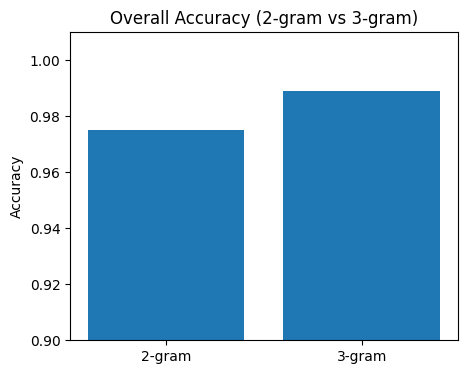

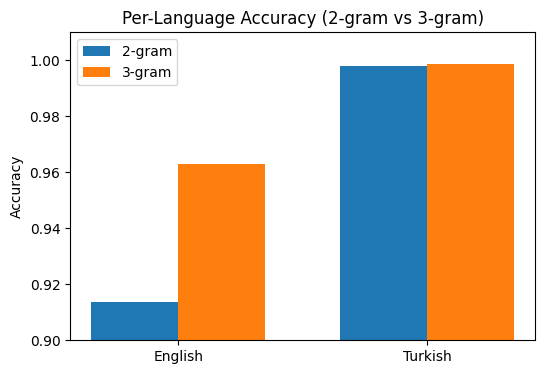


Total misclassified sentences by 3-gram model: 37
Some misclassified examples (up to 10):
  TRUE=English, PRED=Turkish: 'Down the Rabbit-Hole Alice was beginning to get very tired of sitting by her sis...'
  TRUE=English, PRED=Turkish: 'I shall be late!” (when she thought it over afterwards, it occurred to her that ...'
  TRUE=English, PRED=Turkish: 'Let me see: that would be four thousand miles down, I think—” (for, you see, Ali...'
  TRUE=English, PRED=Turkish: 'There seemed to be no use in waiting by the little door, so she went back to the...'
  TRUE=English, PRED=Turkish: '“No, I’ll look first,” she said, “and see whether it’s marked ‘_poison_’ or not”...'
  TRUE=English, PRED=Turkish: '“Come, there’s no use in crying like that!” said Alice to herself, rather sharpl...'
  TRUE=English, PRED=Turkish: '(Alice had been to the seaside once in her life, and had come to the general con...'
  TRUE=English, PRED=Turkish: 'She is such a dear quiet thing,” Alice went on, half to herself, a

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score

print("\n********** 3.2 Advanced Analysis (2-gram vs 3-gram) **********\n")

# 1) get predictions of both models on the whole dataset
y_pred_2gram = []
y_pred_3gram = []

for sent in X:
    y_pred_2gram.append(identify_language(sent, en2, tr2))  # 0 = English, 1 = Turkish
    y_pred_3gram.append(identify_language(sent, en3, tr3))

# overall accuracies
overall_acc_2 = accuracy_score(y, y_pred_2gram)
overall_acc_3 = accuracy_score(y, y_pred_3gram)

print("Overall accuracy:")
print(f"  2-gram: {overall_acc_2:.3f}")
print(f"  3-gram: {overall_acc_3:.3f}")


# 2) per-language accuracy for both models
def per_language_acc(y_true, y_pred):
    correct_en = correct_tr = 0
    total_en = total_tr = 0

    for t, p in zip(y_true, y_pred):
        if t == 0:          # English
            total_en += 1
            if p == 0:
                correct_en += 1
        else:               # Turkish
            total_tr += 1
            if p == 1:
                correct_tr += 1

    acc_en = correct_en / total_en
    acc_tr = correct_tr / total_tr
    return acc_en, acc_tr

acc_en_2, acc_tr_2 = per_language_acc(y, y_pred_2gram)
acc_en_3, acc_tr_3 = per_language_acc(y, y_pred_3gram)

print("\nPer-language accuracy:")
print(f"  2-gram  English: {acc_en_2:.3f} | Turkish: {acc_tr_2:.3f}")
print(f"  3-gram  English: {acc_en_3:.3f} | Turkish: {acc_tr_3:.3f}")


# 3) PLOTS
# 3a) overall accuracy bar plot
plt.figure(figsize=(5,4))
plt.bar(["2-gram", "3-gram"], [overall_acc_2, overall_acc_3])
plt.ylim(0.9, 1.01)
plt.ylabel("Accuracy")
plt.title("Overall Accuracy (2-gram vs 3-gram)")
plt.show()

# 3b) per language accuracy grouped bar plot
labels = ["English", "Turkish"]
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(6,4))
plt.bar(x - width/2, [acc_en_2, acc_tr_2], width, label="2-gram")
plt.bar(x + width/2, [acc_en_3, acc_tr_3], width, label="3-gram")
plt.xticks(x, labels)
plt.ylim(0.9, 1.01)
plt.ylabel("Accuracy")
plt.title("Per-Language Accuracy (2-gram vs 3-gram)")
plt.legend()
plt.show()


# 4) misclassified sentences
misclassified_3 = []
for sent, true_label, pred_label in zip(X, y, y_pred_3gram):
    if true_label != pred_label:
        misclassified_3.append((sent, true_label, pred_label))

print("\nTotal misclassified sentences by 3-gram model:", len(misclassified_3))
print("Some misclassified examples (up to 10):")
for sent, true_l, pred_l in misclassified_3[:10]:
    lang_true = "English" if true_l == 0 else "Turkish"
    lang_pred = "English" if pred_l == 0 else "Turkish"
    print(f"  TRUE={lang_true}, PRED={lang_pred}: '{sent[:80]}...'")


**Question 3.2:** What interesting patterns or insights did you discover from your results? (4-5 sentences)

**I can definetely say that 3 gram model did a great job unexpectedly that much.Another thing is 2 and 3 gram model has really similar accuracy on turkish, this is also interesting. Another thing is as you can see from the explamle sentence that provided "Yeter Alice" the prediction is not clear,but as you can see from "Come Berkay", this has also not clear but has better prediciton from previous one.So The reason behind it should be a due to the language difference effect it .**

# Convert Your Colab Notebook to PDF

### Step 1: Download Your Notebook
- Go to **File → Download → Download .ipynb**
- Save the file to your computer

### Step 2: Upload to Colab
- Click the **📁 folder icon** on the left sidebar
- Click the **upload button**
- Select your downloaded .ipynb file

### Step 3: Run the Code Below
- **Uncomment the cell below** and run the cell
- This will take about 1-2 minutes to install required packages
- When prompted, type your notebook name (e.g.`gs_000000_as2.ipynb`) and press Enter

### The PDF will be automatically downloaded to your computer


In [ ]:
 # Install required packages (this takes about 30 seconds)
 print("Installing PDF converter... please wait...")
 !apt-get update -qq
 !apt-get install -y texlive-xetex texlive-fonts-recommended texlive-plain-generic pandoc > /dev/null 2>&1
 !pip install -q nbconvert

 print("\n" + "="*50)

 # Get notebook name from user
 notebook_name = input("\nEnter your notebook name: ")

 # Add .ipynb if missing
 if not notebook_name.endswith('.ipynb'):
     notebook_name += '.ipynb'

 import os
 notebook_path = f'/content/{notebook_name}'

 # Check if file exists
 if not os.path.exists(notebook_path):
     print(f"\n⚠ Error: '{notebook_name}' not found in /content/")
     print("\nMake sure you uploaded the file using the folder icon (📁) on the left!")
 else:
     print(f"\n✓ Found {notebook_name}")
     print("Converting to PDF... this may take 1-2 minutes...\n")
     # Convert the notebook to PDF
     !jupyter nbconvert --to pdf "{notebook_path}"

     # Download the PDF
     from google.colab import files
     pdf_name = notebook_name.replace('.ipynb', '.pdf')
     pdf_path = f'/content/{pdf_name}'

     if os.path.exists(pdf_path):
         print("✓ SUCCESS! Downloading your PDF now...")
         files.download(pdf_path)
         print("\n✓ Done! Check your downloads folder.")
     else:
         print("⚠ Error: Could not create PDF")

Installing PDF converter... please wait...
W: Skipping acquire of configured file 'main/source/Sources' as repository 'https://r2u.stat.illinois.edu/ubuntu jammy InRelease' does not seem to provide it (sources.list entry misspelt?)


Enter your notebook name: By_2385722

✓ Found By_2385722.ipynb
Converting to PDF... this may take 1-2 minutes...

[NbConvertApp] Converting notebook /content/By_2385722.ipynb to pdf
[NbConvertApp] Support files will be in By_2385722_files/
[NbConvertApp] Making directory ./By_2385722_files
[NbConvertApp] Writing 121724 bytes to notebook.tex
[NbConvertApp] Building PDF
[NbConvertApp] Running xelatex 3 times: ['xelatex', 'notebook.tex', '-quiet']
[NbConvertApp] Running bibtex 1 time: ['bibtex', 'notebook']
[NbConvertApp] WARNING | bibtex had problems, most likely because there were no citations
[NbConvertApp] PDF successfully created
[NbConvertApp] Writing 156355 bytes to /content/By_2385722.pdf
✓ SUCCESS! Downloading your PDF now...


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


✓ Done! Check your downloads folder.
